# Constrained Optimization

In this notebook we use `boax` to extend the getting started workflow by introducing optimization constraints.

In [1]:
from jax import config

config.update("jax_enable_x64", True)

from jax import numpy as jnp
from jax import jit, lax, nn, random, value_and_grad, vmap

import optax
import matplotlib.pyplot as plt

plt.style.use('bmh')

from boax.core import distributions, samplers
from boax.prediction import models, objectives
from boax.optimization import acquisitions, optimizers

As part of the environment we initialize two PRNG keys with a starting seed of 0.

In [2]:
data_key, optimizer_key = random.split(random.key(0))

## Defining the latent objective function

For this example we choose a 4-dimensional function that emulates the mapping of the design decision of an airplane to its utility. We aim to maximize this function the interval of `[0, 1]` for all four dimensions.

In [3]:
def objective(x):
    next_x = x.at[:, [2, 3]].set(1 - x[:, [2, 3]]) * 10 - 5
    return -0.005 * jnp.sum(next_x ** 4 - 16 * next_x ** 2 + 5 * next_x, axis=-1) + 3

Next, we define a cost function that constrains the design decision space.

In [4]:
def cost(x):
    i = jnp.arange(2, 5)
    next_x = x * 20 - 10
    part1 = (next_x[..., 0] - 1)**2
    part2 = jnp.sum(i * (2 * next_x[..., 1:]**2 - next_x[..., :-1])**2, axis=-1)

    return -(part1 + part2) / 100_000 + 2

When defining the objective and cost functions we expect an input of shape `(n, d)`, where `n` indicates the number of examples in the training set and `d` indicates the number of dimensions for each data point.

In [5]:
bounds = jnp.array([[0.0, 1.0]] * 4)

The bounds are of shape `(d, 2)`, where `d` indicates the number of dimensions, each described by a lower and upper bound.

## Generating training data

In this example we assume to have already evaluated the objective function a random starting point drawn from a uniformly random distribution.

In [6]:
x_train = random.uniform(data_key, minval=bounds[:, 0], maxval=bounds[:, 1], shape=(1, 4))
y_train = objective(x_train)
c_train = cost(x_train)

In the following we plot the observations from the evaluation in the context of the latent objective and cost functions.

In [7]:
grid = jnp.linspace(0, 1, 101)
x1, x2 = jnp.meshgrid(grid, grid, indexing="ij")
xs = jnp.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)

In [8]:
axis = ['scaled body length', 'scaled wing span', 'scaled ρ', 'scaled ω']

In [9]:
def visualize(fn):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    dimensions_to_plot = [(0, 1), (1, 2), (2, 3), (0, 3)]
    zeros = jnp.zeros((101 ** 2, 4))
    
    for idx, (i, j) in enumerate(dimensions_to_plot):
        ax = axs[idx // 2][idx % 2]

        ax.scatter(x_train[..., i], x_train[..., j], marker='x', c='k', label='observations')
        
        c = ax.imshow(
            fn(zeros.at[:, [i, j]].set(xs)).reshape(101, 101),
            origin='lower',
            extent=[0, 1, 0, 1],
        )
        
        plt.colorbar(c, ax=ax)
    
        ax.set_xlabel(axis[i], fontsize=15)
        ax.set_ylabel(axis[j], fontsize=15)
        ax.legend(loc='upper left')
    
    plt.show()

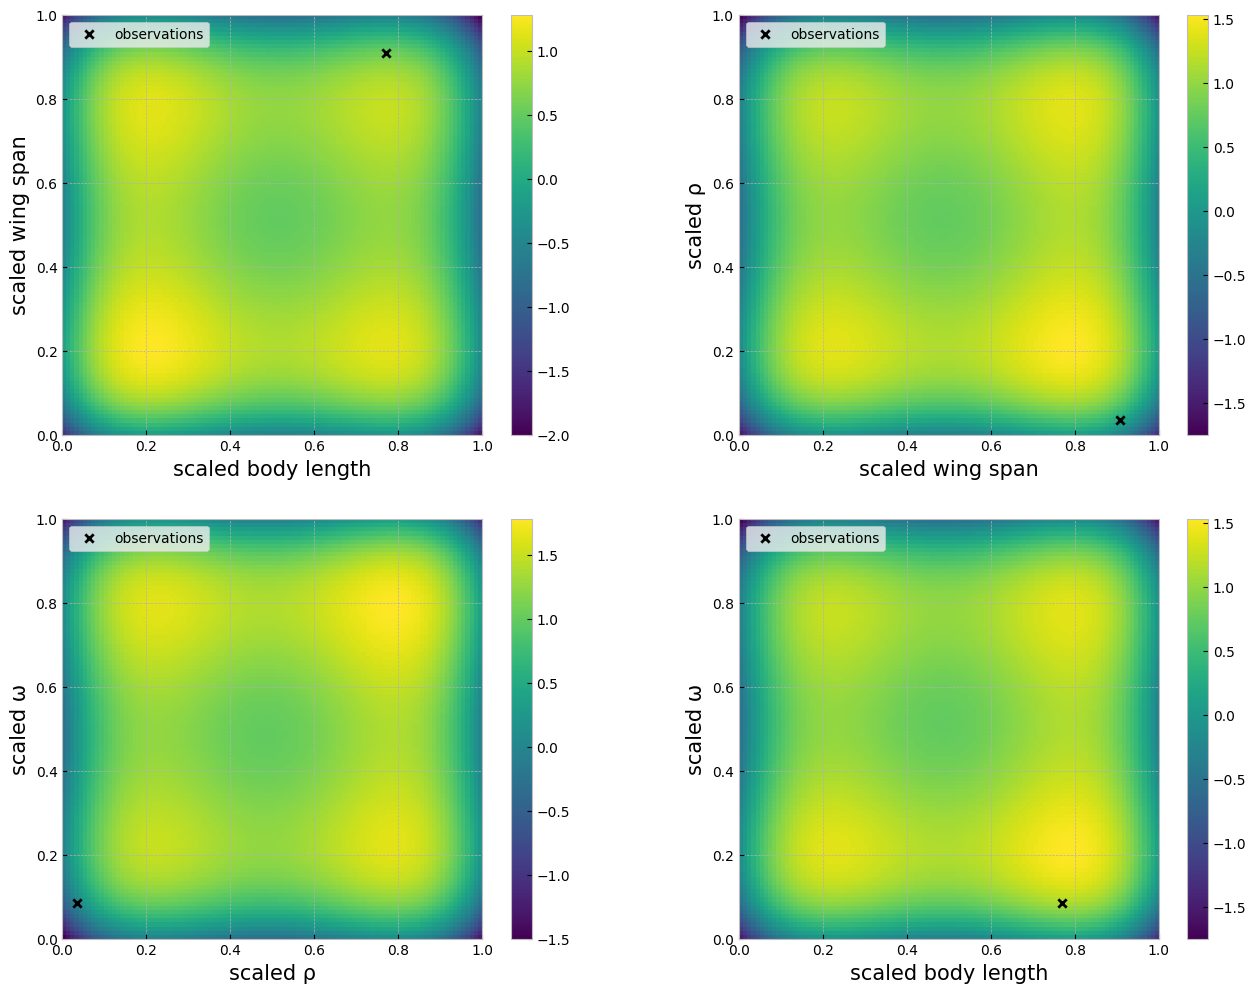

In [10]:
visualize(objective)

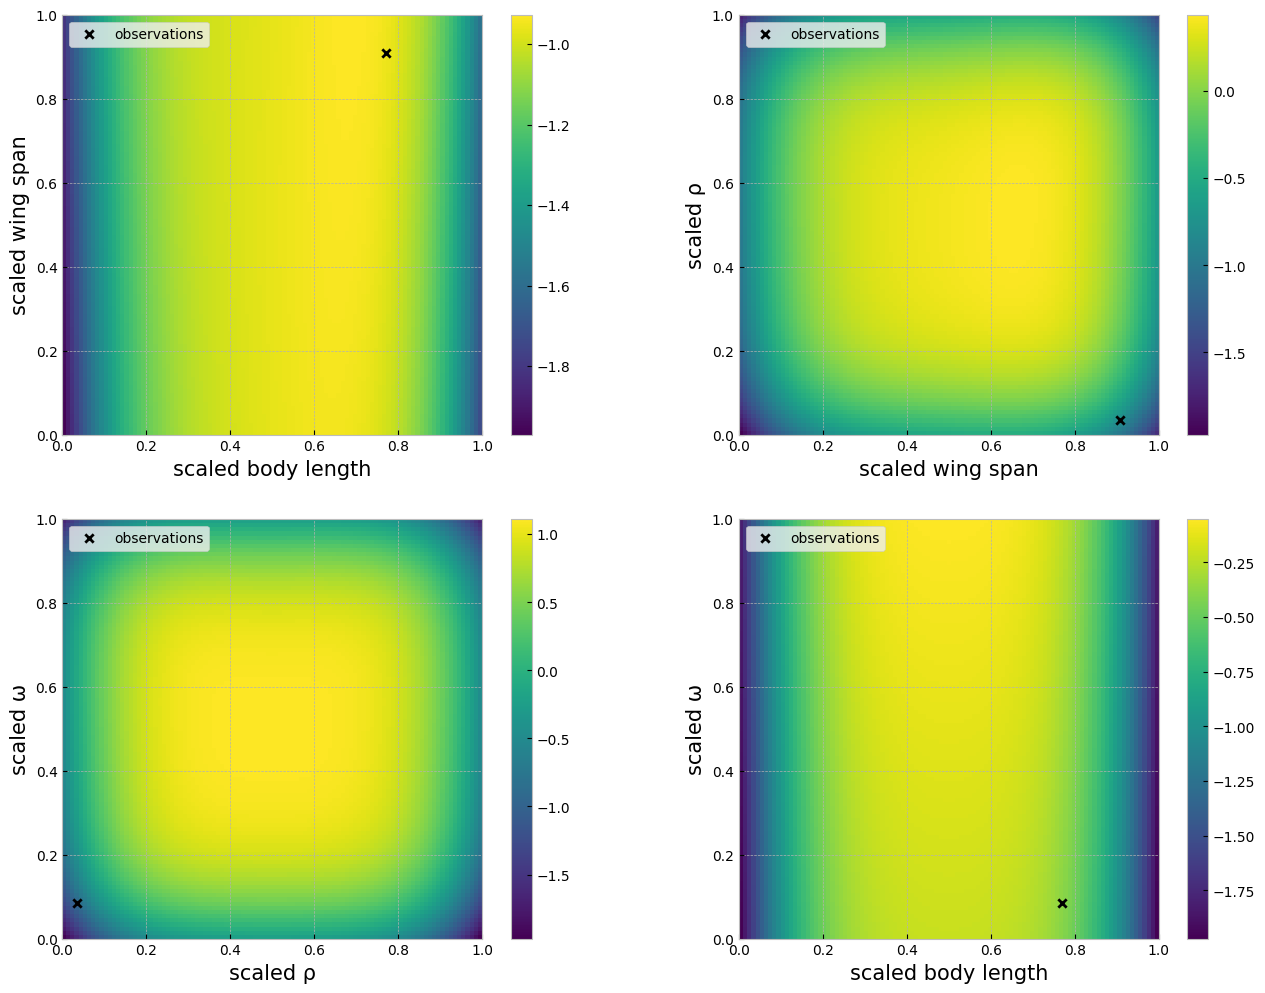

In [11]:
visualize(cost)

## Fitting a Gaussian Process model to the data

With the observations in place, we can now focus on fitting a Gaussian Process model to the training data. We choose a simple Gaussian Process model setup with a constant mean function, a scaled matérn 2.5 kernel, and a gaussian likelihood.

In [12]:
def model_fn(params, x_train, y_train):
    return models.gaussian_process.exact(
        models.means.constant(params['mean']),
        models.kernels.scaled(
            models.kernels.matern_five_halves(nn.softplus(params['length_scale'])),
            nn.softplus(params['amplitude'])
        ),
        models.likelihoods.gaussian(1e-4),
        x_train,
        y_train,
    )

Next, we define the loss function used to fit the model to the training data. For this setup we select the negative log likelihood.

In [13]:
def loss_fn(params, x_train, y_train):
    y_hat = model_fn(params, None, None)(x_train)
    objective = objectives.negative_log_likelihood(
        distributions.multivariate_normal.logpdf
    )

    return objective(y_hat, y_train)

Subsequentely, we initialise the model parameters and the optimizer from the `optax` library. Note, we define a lengthscale parameter of shape (4,), that is, we fit an independent lengthscale parameter for each dimension.

In [14]:
params = {
    'mean': jnp.zeros(()),
    'length_scale': jnp.zeros((4,)),
    'amplitude': jnp.zeros(()),
}

In [15]:
adam = optax.adam(0.01)

Finally, we have everything we need to define the model fitting function.

In [16]:
def fit(x_train, y_train):
    def step(state, i):
        loss, grads = value_and_grad(loss_fn)(state[0], x_train, y_train)
        updates, opt_state = adam.update(grads, state[1])
        params = optax.apply_updates(state[0], updates)

        return (params, opt_state), loss

    (next_params, _), _ = lax.scan(
        jit(step),
        (params, adam.init(params)),
        jnp.arange(500),
    )

    return next_params

## Constructing an acquisition function and selecting the next data points to query

The next step in the bayesian optimization process is the construction of an acqusition function that guides our decision of selecting a new point to query the latent objective function.

In [17]:
batch_size = 1
num_results = 500
num_restarts = 100

In [18]:
sampler = samplers.halton_uniform(
    distributions.uniform.uniform(bounds[:, 0], bounds[:, 1])
)

In [19]:
def optimizer_fn(acqf):
    return optimizers.batch(
        optimizers.initializers.q_batch_nonnegative(
            acqf, sampler, batch_size, num_results, num_restarts,
        ),
        optimizers.solvers.scipy(
            acqf, bounds,
        ),
    )

## Running the experiment

Finally we have everything setup to run the bayesian optimization loop. This time around we will be comparing two different acquisition functions, Expected Improvement (EI) and Constrained Expected Improvement (CEI). We keep track of each policy's progress for later evaluation.

In [20]:
best = {}

The bayesian optimization loop is implemented analogue to the standard loop from the Getting Started guide.

In [21]:
for p in ['ei', 'cei']:
    _x_train = x_train
    _y_train = y_train
    _c_train = c_train

    best[p] = [-2]

    for i in range(50):
        # Fitting
        obj_params = fit(_x_train, _y_train)
        obj_model = models.outcome_transformed(
            model_fn(obj_params, _x_train, _y_train),
            distributions.mvn_to_norm,
        )
        
        fsb_params = fit(_x_train, _c_train)
        fsb_model = models.outcome_transformed(
            model_fn(fsb_params, _x_train, _c_train),
            distributions.mvn_to_norm,
        )

        # Selecting
        match p:
            case 'ei':
                acqf = models.outcome_transformed(
                    vmap(obj_model),
                    acquisitions.expected_improvement(
                        best=jnp.max(_y_train),
                    ),
                )
            case 'cei':
                feasible = _y_train[_c_train <= 0]
                acqf = models.outcome_transformed(
                    models.joined(
                        vmap(obj_model), vmap(fsb_model)
                    ),
                    acquisitions.constrained(
                        acquisitions.expected_improvement(
                            best=jnp.array(-2) if not jnp.any(feasible) else jnp.max(feasible),
                        ),
                        acquisitions.constraints.less_or_equal(
                            bound=0.0  
                        ),
                    )
                )
    
        next_x, _ = optimizer_fn(acqf)(
            random.fold_in(optimizer_key, i)
        )
    
        # Evaluating
        next_y, next_c = objective(next_x), cost(next_x)

        # Updating the training data
        _x_train = jnp.vstack([_x_train, next_x])
        _y_train = jnp.hstack([_y_train, next_y])
        _c_train = jnp.hstack([_c_train, next_c])

        # Visualizing
        feasible = _y_train[_c_train <= 0]
        best[p].append(jnp.array(-2) if not jnp.any(feasible) else jnp.max(feasible))

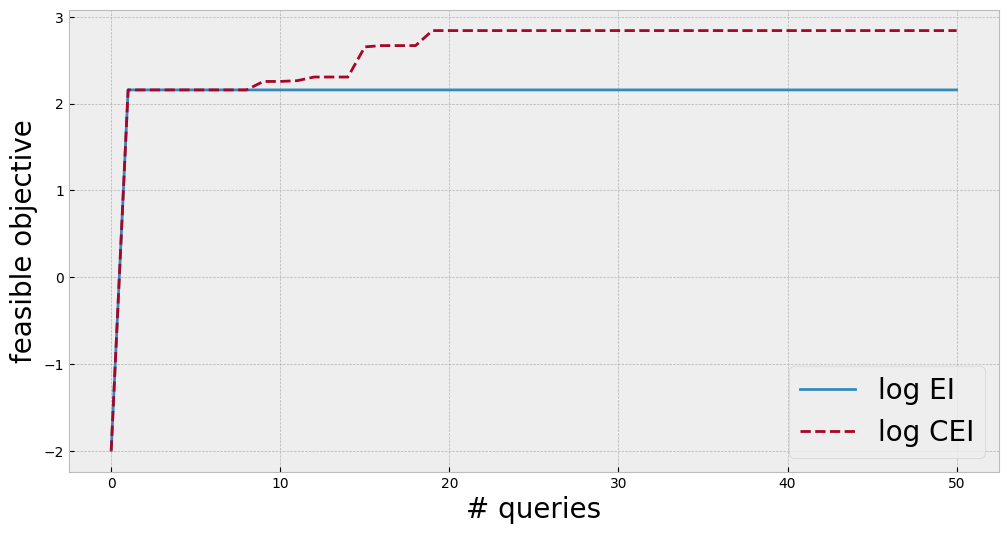

In [22]:
queries = jnp.arange(51)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(queries, best['ei'], label='log EI')
ax.plot(queries, best['cei'], linestyle='--', label='log CEI')

ax.set_xlabel('# queries', fontsize=20)
ax.set_ylabel('feasible objective', fontsize=20)
ax.legend(fontsize=20)

plt.show()